<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_05_1_reg_ridge_lasso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T81-558: Applications of Deep Neural Networks
**Module 5: Regularization and Dropout**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module 5 Material

* **Part 5.1: Part 5.1: Introduction to Regularization: Ridge and Lasso** [[Video]](https://www.youtube.com/watch?v=jfgRtCYjoBs&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_05_1_reg_ridge_lasso.ipynb)
* Part 5.2: Using K-Fold Cross Validation with Keras [[Video]](https://www.youtube.com/watch?v=maiQf8ray_s&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_05_2_kfold.ipynb)
* Part 5.3: Using L1 and L2 Regularization with Keras to Decrease Overfitting [[Video]](https://www.youtube.com/watch?v=JEWzWv1fBFQ&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_05_3_keras_l1_l2.ipynb)
* Part 5.4: Drop Out for Keras to Decrease Overfitting [[Video]](https://www.youtube.com/watch?v=bRyOi0L6Rs8&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_05_4_dropout.ipynb)
* Part 5.5: Benchmarking Keras Deep Learning Regularization Techniques [[Video]](https://www.youtube.com/watch?v=1NLBwPumUAs&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_05_5_bootstrap.ipynb)


# Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow.

In [1]:
try:
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: not using Google CoLab


# Part 5.1: Introduction to Regularization: Ridge and Lasso

Regularization is a technique that reduces overfitting, which occurs when neural networks attempt to memorize training data rather than learn from it. Humans are capable of overfitting as well. Before examining how a machine accidentally overfits, we will first explore how humans can suffer from it.

Human programmers often take certification exams to show their competence in a given programming language. To help prepare for these exams, the test makers often make practice exams available. Consider a programmer who enters a loop of taking the practice exam, studying more, and then retaking the practice exam. The programmer has memorized much of the practice exam at some point rather than learning the techniques necessary to figure out the individual questions. The programmer has now overfitted for the practice exam. When this programmer takes the real exam, his actual score will likely be lower than what he earned on the practice exam.

Although a neural network received a high score on its training data, this result does not mean that the same neural network will score high on data that was not inside the training set. A computer can overfit as well. Regularization is one of the techniques that can prevent overfitting. Several different regularization techniques exist. Most work by analyzing and potentially modifying the weights of a neural network as it trains.  

## L1 and L2 Regularization

L1 and L2 regularization are two standard regularization techniques that can reduce the effects of overfitting. These algorithms can either work with an objective function or as part of the backpropagation algorithm. The regularization algorithm is attached to the training algorithm by adding an objective in both cases.  

These algorithms work by adding a weight penalty to the neural network training. This penalty encourages the neural network to keep the weights to small values. Both L1 and L2 calculate this penalty differently. You can add this penalty calculation to the calculated gradients for gradient-descent-based algorithms, such as backpropagation. The penalty is negatively combined with the objective score for objective-function-based training, such as simulated annealing.

We will look at linear regression to see how L1 and L2 regularization work. The following code sets up the auto-mpg data for this purpose.

In [2]:
from sklearn.linear_model import LassoCV
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import train_test_split 

df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/auto-mpg.csv", 
    na_values=['NA', '?'])

# Handle missing value
df['horsepower'] = df['horsepower'].fillna(df['horsepower'].median())

# Pandas to Numpy
names = ['cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin']
x = df[names].values
y = df['mpg'].values # regression

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=45)

We will use the data just loaded for several examples. The first examples in this part use several forms of linear regression. For linear regression, it is helpful to examine the model's coefficients. The following function is utilized to display these coefficients.

In [3]:
# Simple function to evaluate the coefficients of a regression
%matplotlib inline    
from IPython.display import display, HTML    

def report_coef(names,coef,intercept):
    r = pd.DataFrame( { 'coef': coef, 'positive': coef>=0  }, index = names )
    r = r.sort_values(by=['coef'])
    display(r)
    print(f"Intercept: {intercept}")
    r['coef'].plot(kind='barh', color=r['positive'].map(
        {True: 'b', False: 'r'}))

## Linear Regression

Before jumping into L1/L2 regularization, we begin with linear regression.  Researchers first introduced the L1/L2 form of regularization for [linear regression](https://en.wikipedia.org/wiki/Linear_regression).  We can also make use of L1/L2 for neural networks.  To fully understand L1/L2 we will begin with how we can use them with linear regression.

The following code uses linear regression to fit the auto-mpg data set.  The RMSE reported will not be as good as a neural network.

Final score (RMSE): 3.0019345985860784


,coef,positive
cylinders,-0.427721,False
weight,-0.007255,False
horsepower,-0.005491,False
displacement,0.020166,True
acceleration,0.138575,True
year,0.783047,True
origin,1.003762,True


Intercept: -19.101231042200112


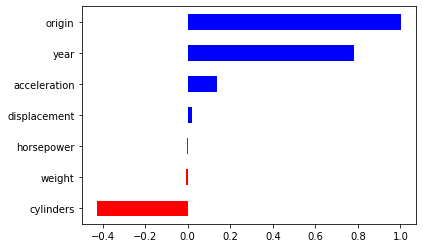

In [4]:
import sklearn

# Create linear regression
regressor = sklearn.linear_model.LinearRegression()

# Fit/train linear regression
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print(f"Final score (RMSE): {score}")

report_coef(
  names,
  regressor.coef_,
  regressor.intercept_)

## L1 (Lasso) Regularization

L1 regularization, also called LASSO (Least Absolute Shrinkage and Selection Operator) should be used to create sparsity in the neural network. In other words, the L1 algorithm will push many weight connections to near 0. When the weight is near 0, the program drops it from the network. Dropping weighted connections will create a sparse neural network.

Feature selection is a useful byproduct of sparse neural networks. Features are the values that the training set provides to the input neurons. Once all the weights of an input neuron reach 0, the neural network training determines that the feature is unnecessary. If your data set has many unnecessary input features, L1 regularization can help the neural network detect and ignore unnecessary features.

L1 is implemented by adding the following error to the objective to minimize:

$$ E_1 = \alpha \sum_w{ |w| } $$

You should use L1 regularization to create sparsity in the neural network. In other words, the L1 algorithm will push many weight connections to near 0. When the weight is near 0, the program drops it from the network. Dropping weighted connections will create a sparse neural network.

The following code demonstrates lasso regression. Notice the effect of the coefficients compared to the previous section that used linear regression.

Final score (RMSE): 3.0604021904033303


,coef,positive
cylinders,-0.012995,False
weight,-0.007328,False
horsepower,-0.002715,False
displacement,0.011601,True
acceleration,0.114391,True
origin,0.708222,True
year,0.777480,True


Intercept: -18.506677982383252


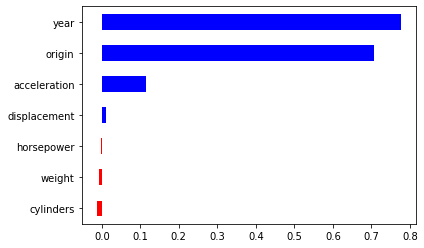

In [5]:
import sklearn
from sklearn.linear_model import Lasso

# Create linear regression
regressor = Lasso(random_state=0,alpha=0.1)

# Fit/train LASSO
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print(f"Final score (RMSE): {score}")

report_coef(
  names,
  regressor.coef_,
  regressor.intercept_)


## L2 (Ridge) Regularization

You should use Tikhonov/Ridge/L2 regularization when you are less concerned about creating a space network and are more concerned about low weight values.  The lower weight values will typically lead to less overfitting. 

$$ E_2 = \alpha \sum_w{ w^2 } $$

Like the L1 algorithm, the $\alpha$ value determines how important the L2 objective is compared to the neural network’s error.  Typical L2 values are below 0.1 (10%).  The main calculation performed by L2 is the summing of the squares of all of the weights.  The algorithm will not sum bias values.

You should use L2 regularization when you are less concerned about creating a space network and are more concerned about low weight values.  The lower weight values will typically lead to less overfitting.  Generally, L2 regularization will produce better overall performance than L1.  However, L1 might be useful in situations with many inputs, and you can prune some of the weaker inputs.

The following code uses L2 with linear regression (Ridge regression):

Final score (RMSE): {score}


,coef,positive
cylinders,-0.421393,False
weight,-0.007257,False
horsepower,-0.005385,False
displacement,0.020006,True
acceleration,0.138470,True
year,0.782889,True
origin,0.994621,True


Intercept: -19.07980074425469


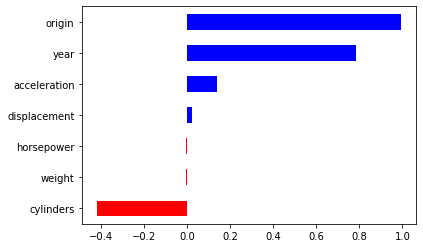

In [7]:
import sklearn
from sklearn.linear_model import Ridge

# Create linear regression
regressor = Ridge(alpha=1)

# Fit/train Ridge
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {score}")

report_coef(
  names,
  regressor.coef_,
  regressor.intercept_)


## ElasticNet Regularization

The ElasticNet regression combines both L1 and L2.  Both penalties are applied.  The amount of L1 and L2 are governed by the parameters alpha and beta.

$$ a * {\rm L}1 + b * {\rm L}2 $$

Final score (RMSE): 3.0450899960775013


,coef,positive
cylinders,-0.274010,False
weight,-0.007303,False
horsepower,-0.003231,False
displacement,0.016194,True
acceleration,0.132348,True
year,0.777482,True
origin,0.782781,True


Intercept: -18.389355690429767


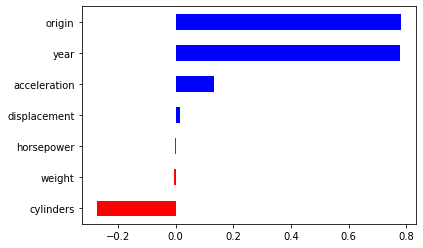

In [8]:
import sklearn
from sklearn.linear_model import ElasticNet

# Create linear regression
regressor = ElasticNet(alpha=0.1, l1_ratio=0.1)

# Fit/train LASSO
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print(f"Final score (RMSE): {score}")

report_coef(
  names,
  regressor.coef_,
  regressor.intercept_)